# Getting additional bird data

`# Step 1. Retrieving data from eBird`

Go to  https://media.ebird.org/catalog?regionCode=AU&sort=rating_rank_desc&mediaType=photo.
- Replace the region code with your chosen region, e.g. US, GB, CA.
- Refer to the Alpha-2 codes [here](https://www.iban.com/country-codes) for the full list of options.

Click 'More Results' a bunch of times.

Right click on the page > 'Inspect' > 'Console' > Copy and paste the code from [`get_bird_images.js`](./crawlers/get_bird_images.js) into the Console > Run

Right-click on the output > 'Copy object' > Paste into a new file called `new_images.json`.

Important: Your file MUST be called `new_images.json` and it MUST be stored in the **same directory** as this notebook. 

`# Step 2. Convert to CSV`

In [ ]:
! pip3 install jq

In [ ]:
# Convert from a json to csv
! jq -r '.[] | [.alt, .src] | @csv' new_images.json > new_images.csv

`# Step 3. Merge wih existing data`

Should the new images be merged with an **existing** set of images?

If YES, ensure your existing images are stored as `images.csv` in the same directory as this notebook. Then uncomment and run the below cell.

If NO, skip to Step 4.

In [ ]:
## Append existing images to new image file
## Important, this assumes the image file has a header, it excludes the first line of the existing images file when appending

#! awk 'FNR>1' images.csv >> new_images.csv

`# Step 4. Categorise`

For harder modes to work in twitch or tweek, birds need to be categorised into groups of similar birds.

I wrote SQL for doing said categorisation in BigQuery, [bird_grouping.sql](../sql/bird_grouping.sql). That SQL has since been rewritten for SQLite compatability, [sqlite_friendly_grouping.sql](../sql/sqlite_friendly_grouping.sql)

This section of the notebook uses the categorising SQL to add a category field to `new_images.csv` using SQLite and output it to a new location `new_images_categorised.sql`.

In [47]:
! brew install sqlite

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 3.45.0, run:
  brew reinstall sqlite


In [48]:
%%bash

sqlite3 2> >(grep -v 'expected 3 columns but found 2 - filling the rest with NULL' >&2)

DROP TABLE IF EXISTS 'birds';
CREATE TABLE birds(name text, image_id text, category text);
.mode csv
.import new_images.csv birds
.mode column
SELECT * FROM birds LIMIT 5;
.mode csv
.output new_images_categorised.csv
.read ../sql/sqlite_friendly_grouping.sql
.output stdout


new_images.csv:1: expected 3 columns but found 5 - extras ignored
new_images.csv:2: expected 3 columns but found 5 - extras ignored
new_images.csv:3: expected 3 columns but found 5 - extras ignored
new_images.csv:4: expected 3 columns but found 5 - extras ignored
new_images.csv:5: expected 3 columns but found 5 - extras ignored
new_images.csv:6: expected 3 columns but found 5 - extras ignored
new_images.csv:7: expected 3 columns but found 5 - extras ignored
new_images.csv:8: expected 3 columns but found 5 - extras ignored
new_images.csv:9: expected 3 columns but found 5 - extras ignored
new_images.csv:10: expected 3 columns but found 5 - extras ignored
new_images.csv:11: expected 3 columns but found 5 - extras ignored
new_images.csv:12: expected 3 columns but found 5 - extras ignored
new_images.csv:13: expected 3 columns but found 5 - extras ignored
new_images.csv:14: expected 3 columns but found 5 - extras ignored
new_images.csv:15: expected 3 columns but found 5 - extras ignored
new_

name  image_id                category 
----  ----------------------  ---------
      name                    image_id 
0     Asian Green Bee-eater   429960671
1     Sri Lanka Frogmouth     612850408
2     Gray-headed Fish-Eagle  415306831
4     Pheasant-tailed Jacana  714944   


new_images.csv:243: expected 3 columns but found 5 - extras ignored
new_images.csv:244: expected 3 columns but found 5 - extras ignored
new_images.csv:245: expected 3 columns but found 5 - extras ignored
new_images.csv:246: expected 3 columns but found 5 - extras ignored
new_images.csv:247: expected 3 columns but found 5 - extras ignored
new_images.csv:248: expected 3 columns but found 5 - extras ignored
new_images.csv:249: expected 3 columns but found 5 - extras ignored
new_images.csv:250: expected 3 columns but found 5 - extras ignored
new_images.csv:251: expected 3 columns but found 5 - extras ignored
new_images.csv:252: expected 3 columns but found 5 - extras ignored


`# Step 5. Inspect`

In [49]:
# Import data into a dataframe for inspection
import pandas as pd
df_images_plus_latest = pd.read_csv('new_images_categorised.csv')
df_images_plus_latest.sample(10)

,name,image_id,category
91,135.0,Gray-headed Swamphen,NaN
44,62.0,Chestnut-backed Owlet,NaN
232,337.0,Purple Sunbird,NaN
193,274.0,Loten's Sunbird,NaN
231,332.0,Knob-billed Duck,NaN
6,6.0,Asian Woolly-necked Stork,NaN
237,343.0,Brahminy Kite,NaN
178,258.0,Brown Fish-Owl,NaN
116,170.0,Sri Lanka Junglefowl,NaN
125,184.0,Green Imperial-Pigeon,NaN


In [50]:
df_images_plus_latest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      251 non-null    float64
 1   image_id  252 non-null    object 
 2   category  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB


In [51]:
# Check for null categories. If any, modify sqlite_friendly_grouping.sql to fix.
df_images_plus_latest[df_images_plus_latest.category.isnull()].name.unique()

array([ nan,   0.,   1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  18.,  20.,  24.,  28.,  29.,
        30.,  31.,  32.,  33.,  37.,  38.,  39.,  41.,  42.,  43.,  44.,
        45.,  47.,  48.,  49.,  51.,  53.,  54.,  56.,  57.,  58.,  61.,
        62.,  63.,  66.,  68.,  69.,  71.,  72.,  74.,  76.,  77.,  78.,
        79.,  80.,  81.,  83.,  84.,  85.,  86.,  88.,  90.,  91.,  94.,
        95.,  96.,  97.,  98.,  99., 104., 105., 107., 108., 109., 110.,
       111., 113., 114., 115., 116., 117., 118., 124., 125., 126., 127.,
       128., 129., 131., 135., 137., 138., 139., 142., 143., 144., 146.,
       147., 148., 149., 152., 153., 154., 155., 156., 157., 158., 160.,
       161., 163., 164., 166., 167., 168., 170., 171., 173., 175., 177.,
       178., 179., 180., 182., 184., 185., 187., 188., 190., 192., 193.,
       194., 195., 196., 197., 198., 200., 201., 206., 209., 212., 213.,
       214., 216., 217., 219., 220., 222., 223., 22

IndexError: index 0 is out of bounds for axis 0 with size 0

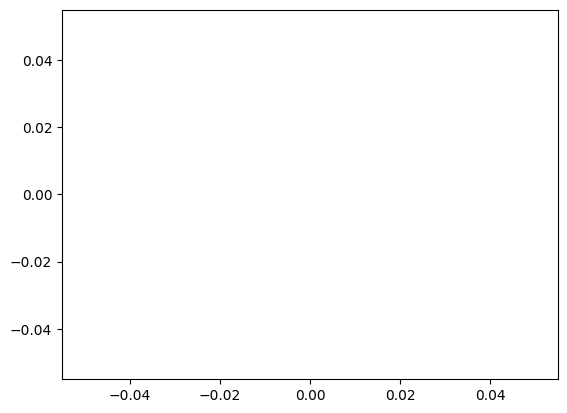

In [52]:
# Check distribution of grouping
df_images_plus_latest['category'].value_counts().plot(kind='barh')

In [ ]:
# Check for duplicated images
df_images_plus_latest[df_images_plus_latest.image_id.duplicated()]

,Unnamed: 0,name,image_id,category,row_num


<Axes: ylabel='name'>

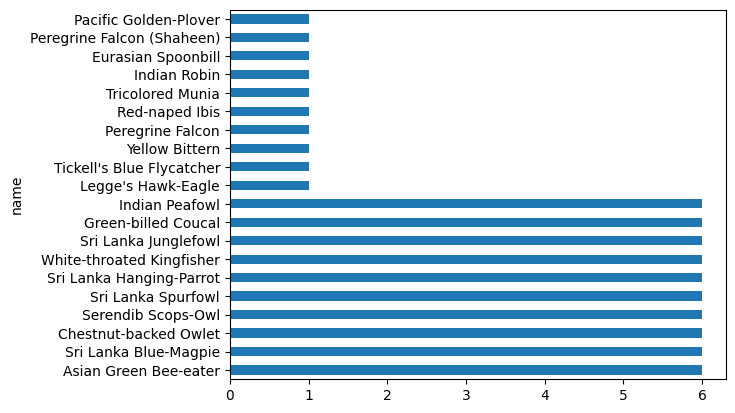

In [ ]:
# Check for species grouping - (too many to plot so just showing top and bottom 10)
pd.concat([df_images_plus_latest['name'].value_counts().head(10), df_images_plus_latest['name'].value_counts().tail(10)]).plot(kind='barh')

`# Step 6. Optional Extra Cleaning`

In [ ]:
# Cut back over-indexed birds

vc = df_images_plus_latest.name.value_counts()
overindexed_species = df_images_plus_latest.name.value_counts()[vc > 10]

print(f'The median number of images per species is {vc.median()}')
print(f'{overindexed_species.count()} species have more than 10 images')
print(f'They are: \n {overindexed_species}')

In [ ]:
# Reduce max images per species to 10

df_images_plus_latest['row_num'] = df_images_plus_latest.sort_values(['name', 'image_id'], ascending=True).groupby(['name', 'category']).cumcount() + 1
df_reduced = df_images_plus_latest[df_images_plus_latest.row_num <= 10]

df_reduced[['name','image_id','category']].to_csv('new_images_categorised_reduced.csv', index=False)

In [ ]:
# Check distribution of grouping
df_reduced['category'].value_counts().plot(kind='barh')

# Done! 🎉

Your fresh twitch or tweek images are ready to go